In [1]:
import os
import MV2,cdms2
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import hsv_to_rgb
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Rectangle
import datetime
#import brypy as bp
import cftime
import scipy.stats as stats
from diurnal_cycle import  composite_diurnal_cycle
%matplotlib inline

In [2]:
run_names = {'hr':    '20200517-maint-1.0-tro.A_WCYCL20TRS_CMIP6_HR.ne120_oRRS18v3_ICG.unc11',
             'lr':    '20210104.maint-1.0-A_WCYCL20TRS_CMIP6_LRtunedHR.ne30_oECv3_ICG.cori-knl.unc11',
             'gpcp':  'pr_day_GPCP-1-3_BE_gn_19961002-20170101',
             'trmm':  'pr_3hr_TRMM-3B43v-7_BE_gn_v20200707_',
             'trmm2': 'TRMM_nat_to_1x1',}

In [3]:
dir_parent = os.path.join(os.sep + 'global', 'cfs', 'cdirs', 'e3sm','www','xzheng', 'tests' + os.sep)
dir_hr_d   = os.path.join(dir_parent, run_names['hr']+'.cam.h5_dc_notnmlz','diurnal_cycle','TRMM-3B43v-7_3hr' + os.sep)
dir_lr_d   = os.path.join(dir_parent, run_names['lr']+'.cam.h5_dc_notnmlz','diurnal_cycle','TRMM-3B43v-7_3hr' + os.sep)

In [4]:
data_filename='TRMM-3B43v-7_3hr-PRECT-ANN-global_test.nc'
obs_filename='TRMM-3B43v-7_3hr-PRECT-ANN-global_ref.nc'
f_hr=cdms2.open(''.join([dir_hr_d,data_filename]))
f_lr=cdms2.open(''.join([dir_lr_d,data_filename]))


In [19]:
PRECT_phase=f_hr['PRECT_PHASE']

In [5]:
dss = dict()
dss['map'] = dict()
dss['map']['hrnat'] = xr.open_dataset(dir_hr_d + data_filename)
dss['map']['lrnat'] = xr.open_dataset(dir_lr_d + data_filename)
dss['map']['trmm'] = xr.open_dataset(dir_lr_d + obs_filename)

In [6]:
def color_average(rgb1, rgb2):
    """
    Average two rgb tuples together and return their average
    The average of RGB colors is sqrt( (color1**2 + color2**2) / 2 )
    rgb1 : tuple or list or np.array
    rgb2 : tuple or list or np.array
    Returns
    -------
    red, green, blue : tuple
    """
    red   = np.sqrt( (rgb1[0]**2 + rgb2[0]**2) * 0.5 )
    green = np.sqrt( (rgb1[1]**2 + rgb2[1]**2) * 0.5 )
    blue  = np.sqrt( (rgb1[2]**2 + rgb2[2]**2) * 0.5 )
    return red, green, blue

In [7]:
fst        = 24
fsa        = 20
fsx        = 14
figure_dir = '/global/cfs/cdirs/e3sm/www/xzheng/tests'
dpi        = 300
cmap_diff  = 'RdBu_r'
#cmap_diff  = bp.read_colormap('diverging_bwr')
#cmap_pr    = bp.read_colormap('prcp')

# Using the blues from Alan
#lr_hex     = '#5454b4'
#hr_hex     = '#94bcbc'
lr_rgb     = np.array([84,84,180])/255
hr_rgb     = np.array([148,188,188])/255
avg_rgb    = color_average(hr_rgb, lr_rgb)  # averages of rgb colors are sqrt( (color1**2 + color2**2) / 2 )

# Switch back to greens
lr_rgb  = 'darkgreen'
avg_rgb = 'forestgreen'
hr_rgb  = 'limegreen'

fname      = '/global/cfs/cdirs/e3sm/mapping/maps/huc2_maps/huc2_shapes/HUC2all.shp'
shapes     = Reader(fname)
all_shapes = cfeature.ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(), edgecolor='blue')

In [8]:
reader            = Reader(fname)
huc_basins        = reader.records()
huc_number        = lambda huc_basin: huc_basin.attributes['HUC2']
huc_basins_sorted = sorted(huc_basins, key=huc_number)[:18]

In [28]:
for hbs in huc_basins_sorted:
    print(hbs.attributes['HUC2'], hbs.attributes['NAME'])

01 New England Region
02 Mid Atlantic Region
03 South Atlantic-Gulf Region
04 Great Lakes Region
05 Ohio Region
06 Tennessee Region
07 Upper Mississippi Region
08 Lower Mississippi Region
09 Souris-Red-Rainy Region
10 Missouri Region
11 Arkansas-White-Red Region
12 Texas-Gulf Region
13 Rio Grande Region
14 Upper Colorado Region
15 Lower Colorado Region
16 Great Basin Region
17 Pacific Northwest Region
18 California Region


In [9]:
reader            = Reader(fname)
huc_basins_recs   = reader.records()
huc_basins_geos   = reader.geometries()
huc_basins        = zip(reader.records(), reader.geometries())
huc_number        = lambda huc_basin: huc_basin.attributes['HUC2']
huc_recs_sorted   = sorted(huc_basins_recs, key=huc_number)[:18]
#huc_geos_sorted   = sorted(huc_basins_geos, key=huc_number)[:18]

In [10]:
basin_centers = dict(huc2_01=dict(lon=288, lat=43), huc2_02=dict(lon=284, lat=41), huc2_03=dict(lon=276, lat=32), 
                     huc2_04=dict(lon=274, lat=44), huc2_05=dict(lon=276, lat=38.5), huc2_06=dict(lon=273, lat=35),
                     huc2_07=dict(lon=268, lat=42), huc2_08=dict(lon=268.5, lat=33), huc2_09=dict(lon=263, lat=48), 
                     huc2_10=dict(lon=258, lat=43), huc2_11=dict(lon=262, lat=36), huc2_12=dict(lon=262, lat=31),
                     huc2_13=dict(lon=254, lat=33), huc2_14=dict(lon=251, lat=39), huc2_15=dict(lon=248, lat=34),
                     huc2_16=dict(lon=243, lat=40), huc2_17=dict(lon=242, lat=46), huc2_18=dict(lon=241, lat=36))

NameError: name 'cax1' is not defined

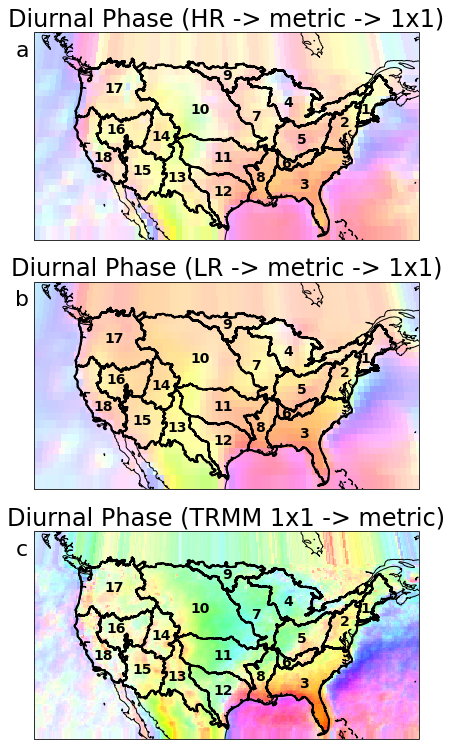

In [12]:
fig  = plt.figure(figsize=(18,13))
gs1  = gridspec.GridSpec(nrows=3, ncols=1, right=0.48)
#gs1c = gridspec.GridSpec(nrows=1, ncols=1, left=0.5, right=0.94)
ax1  = plt.subplot(gs1[0], projection=ccrs.Robinson(central_longitude=260))
ax2  = plt.subplot(gs1[1], projection=ccrs.Robinson(central_longitude=260))
ax3  = plt.subplot(gs1[2], projection=ccrs.Robinson(central_longitude=260))
#cax1 = plt.subplot(gs1c[0], polar=True)
#kax1 = fig.add_axes([0.86, 0.13, 0.08, .1])


# Let's try to replicate the diurnal cycle plot
# Borrowing from e3sm_diags
var1 = dss['map']['hrnat']['PRECT_PHASE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
amp1 = dss['map']['hrnat']['PRECT_AMPLITUDE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
var2 = dss['map']['lrnat']['PRECT_PHASE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
amp2 = dss['map']['lrnat']['PRECT_AMPLITUDE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
var3 = dss['map']['trmm']['PRECT_PHASE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
amp3 = dss['map']['trmm']['PRECT_AMPLITUDE'].sel(lon=slice(200,320)).sel(lat=slice(25,50))
max_amp  = max(amp1.max(), amp2.max(), amp3.max())
img_hsv1 = np.dstack(((var1 / 24. - 0.5) % 1, (amp1/max_amp)**0.5, np.ones_like(amp1)))
img_hsv2 = np.dstack(((var2 / 24. - 0.5) % 1, (amp2/max_amp)**0.5, np.ones_like(amp2)))
img_hsv3 = np.dstack(((var3 / 24. - 0.5) % 1, (amp3/max_amp)**0.5, np.ones_like(amp3)))

img_rgb1 = hsv_to_rgb(img_hsv1)
img_rgb2 = hsv_to_rgb(img_hsv2)
img_rgb3 = hsv_to_rgb(img_hsv3)
img_extent = [230, 295, 24, 50]
img_array1 = xr.DataArray(img_rgb1, coords={'lat':dss['map']['hrnat']['lat'].sel(lat=slice(25,50)),
                                           'lon':dss['map']['hrnat']['lon'].sel(lon=slice(200,320)),
                                           'rgb':range(3)}, dims=('lat', 'lon', 'rgb'))
img_array2 = xr.DataArray(img_rgb2, coords={'lat':dss['map']['lrnat']['lat'].sel(lat=slice(25,50)),
                                           'lon':dss['map']['lrnat']['lon'].sel(lon=slice(200,320)),
                                           'rgb':range(3)}, dims=('lat', 'lon', 'rgb'))
img_array3 = xr.DataArray(img_rgb3, coords={'lat':dss['map']['trmm']['lat'].sel(lat=slice(25,50)),
                                           'lon':dss['map']['trmm']['lon'].sel(lon=slice(200,320)),
                                           'rgb':range(3)}, dims=('lat', 'lon', 'rgb'))

map1 = img_array1.plot.imshow(ax=ax1, x='lon', y='lat', transform=ccrs.PlateCarree(), add_colorbar=True)
map2 = img_array2.plot.imshow(ax=ax2, x='lon', y='lat', transform=ccrs.PlateCarree(), add_colorbar=True)
map3 = img_array3.plot.imshow(ax=ax3, x='lon', y='lat', transform=ccrs.PlateCarree(), add_colorbar=True)

ax1.set_extent([230, 295, 24, 50]), ax1.coastlines(), ax1.set_title('Diurnal Phase (HR -> metric -> 1x1)', fontsize=fst)
ax1.add_feature(all_shapes, facecolor='none', edgecolor='black', linewidth=2)
ax2.set_extent([230, 295, 24, 50]), ax2.coastlines(), ax2.set_title('Diurnal Phase (LR -> metric -> 1x1)', fontsize=fst)
ax2.add_feature(all_shapes, facecolor='none', edgecolor='black', linewidth=2)
ax3.set_extent([230, 295, 24, 50]), ax3.coastlines(), ax3.set_title('Diurnal Phase (TRMM 1x1 -> metric)', fontsize=fst)
ax3.add_feature(all_shapes, facecolor='none', edgecolor='black', linewidth=2)

for huc2 in range(18):
    pstr = f"{huc2+1:02d}"
    hstr = 'huc2_' + pstr
    ax1.text(basin_centers[hstr]['lon'], basin_centers[hstr]['lat'], str(huc2+1), 
             horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
             fontsize=fsx, color='black', fontweight='bold')
    ax2.text(basin_centers[hstr]['lon'], basin_centers[hstr]['lat'], str(huc2+1), 
             horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
             fontsize=fsx, color='black', fontweight='bold')
    ax3.text(basin_centers[hstr]['lon'], basin_centers[hstr]['lat'], str(huc2+1), 
             horizontalalignment='center', verticalalignment='center', transform=ccrs.PlateCarree(),
             fontsize=fsx, color='black', fontweight='bold')
letters = ['a', 'b', 'c']
for ax, letter in zip([ax1, ax2, ax3], letters):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0] - 0.03 * (xlim[1] - xlim[0]), ylim[1] - 0.09 * (ylim[1] - ylim[0]),
            letter, fontsize=fsa+2, ha='center', va='center')
cax1.text(0.25 * np.pi, 0.8, 'd', fontsize=fsa+2, ha='center', va='center')

kax1.set_xlim([0.5,3.5])
kax1.set_ylim([0.5,3.5])
kax1.set_xticks([0])
kax1.set_yticks([0])
kax1.text(1.9, 3, 'HR', fontsize=fsa, ha='left', va='center')
kax1.text(1.9, 2, 'LR', fontsize=fsa, ha='left', va='center')
kax1.text(1.9, 1, 'TRMM', fontsize=fsa, ha='left', va='center')
kax1.add_patch(Rectangle((0.65,2.75), 1, .5, linewidth=1, edgecolor='k', facecolor=hr_rgb))
kax1.add_patch(Rectangle((0.65,1.75), 1, .5, linewidth=1, edgecolor='k', facecolor=lr_rgb))
kax1.add_patch(Rectangle((0.65,0.75), 1, .5, linewidth=1, edgecolor='k', facecolor='white'))
plt.show()